In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import necessary libraries

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D,Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import numpy as np
from scipy.ndimage import rotate, shift,zoom
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from scipy.ndimage import rotate, zoom, affine_transform
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
import matplotlib.pyplot as plt

#### Reading the Data

In [160]:
# Reading the data from data_labels_mainData csv files
data_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data-1/data_labels.csv')

# Perform one-hot encoding using pandas' get_dummies function
one_hot_encoded = pd.get_dummies(data_main['high_level_emotion'])
data_main.drop('high_level_emotion', axis=1, inplace=True)
data_main = pd.concat([data_main, one_hot_encoded], axis=1)

# Define columns to drop from the dataset
columns_to_drop = ['subject', 'sequence', 'image_index', 'file_prefix']
data_main = data_main.drop(columns=columns_to_drop)

# Handle missing values by filling 'AU25' with 0
data_main['AU25'] = data_main['AU25'].fillna(int(0))

# Print columns with NaN values and their counts
nan_values = data_main.isna().sum()

In [110]:
data_main.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,filepath,AU17,AU1,AU2,AU25,AU27,AU4,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,negative,positive,surprise
0,./cohn-kanade-images/S005/001/S005_001_0000001...,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,./cohn-kanade-images/S010/001/S010_001_0000001...,0,1,1,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,./cohn-kanade-images/S010/002/S010_002_0000001...,0,1,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,./cohn-kanade-images/S010/003/S010_003_0000001...,1,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,./cohn-kanade-images/S010/004/S010_004_0000001...,1,0,0,0.0,0,1,1,1,1,0,0,0,0,0,0,1,0,0


## Exploring the data

#### Class distribution of high level emotion

negative    328
surprise    111
positive    121
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


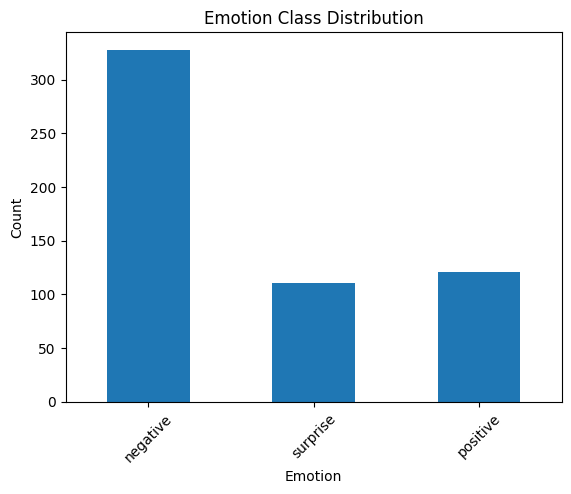

In [111]:
# Define the target column names you want to analyze
target_column_name = ['negative', 'surprise', 'positive']

# Calculate the sum of each target column to get class distribution
class_distribution = data_main[target_column_name].sum()

# Print the class distribution
print(class_distribution)

# Create a bar plot for class distribution
class_distribution.plot(kind='bar')

# Set labels and title for the plot
plt.xlabel('Emotion')  # X-axis label
plt.ylabel('Count')    # Y-axis label
plt.title('Emotion Class Distribution')  # Title of the plot

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()



Ideally, it's crucial to maintain balanced class distributions during training. This ensures that the model encounters examples of "Negative," "Surprise," and "Positive" classes equally. A skewed distribution, such as having more "Negative" examples compared to "Surprise" and "Positive," can lead to biased model behavior. This bias might cause the model to struggle with accurate classifications for the minority classes. Consequently, most misclassifications could be associated with the "Surprise" and "Positive" classes.

the distribution is as follows Negative:Surprise:Positive:: 59.35%:20.25%:20.40%

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AU1     177.0
AU2     117.0
AU4     194.0
AU6     123.0
AU11     34.0
AU12    131.0
AU14     37.0
AU15     94.0
AU23     60.0
AU24     58.0
AU7     121.0
AU17    202.0
AU25    291.0
AU26     41.0
AU27     81.0
dtype: float64


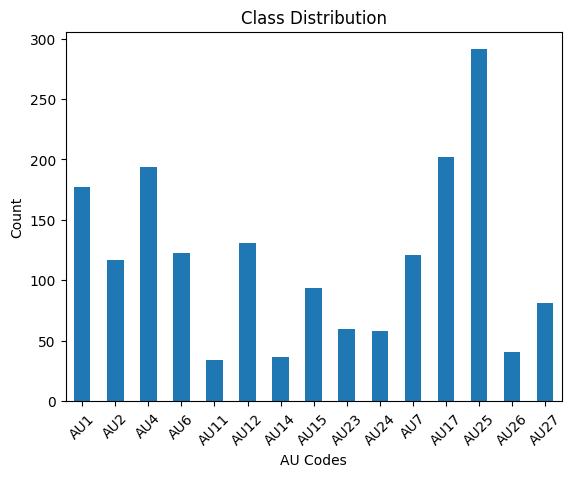

In [112]:
# Define a list of AU code columns you want to analyze
AUcodeColumns = ['AU1', 'AU2', 'AU4', 'AU6', 'AU11', 'AU12', 'AU14', 'AU15', 'AU23', 'AU24', 'AU7', 'AU17', 'AU25', 'AU26', 'AU27']

# Calculate class distribution by summing up occurrences of each label in the specified AU code columns
class_distribution = data_main[AUcodeColumns].sum()

# Print the calculated class distribution
print(class_distribution)

# Create a bar plot to visualize the class distribution
class_distribution.plot(kind='bar')

# Set labels and title for the plot
plt.xlabel('AU Codes')  # X-axis label
plt.ylabel('Count')     # Y-axis label
plt.title('Class Distribution')  # Title of the plot

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


As per the reference paper [1], emotions are categorized as follows: "Angry," "Disgust," "Fear," "Sadness," and "Contempt" are considered as negative emotions, while "Happy" falls into the positive category, and "Surprise" remains distinct.

To identify a negative emotion in an image, the presence of these AU codes is crucial: AU23, AU24, AU1, AU2, AU4, AU15, AU11, AU6, AU14.

For portraying a happy emotion, an image should showcase AU12.

To signify a surprise emotion, the key AU codes are AU1 and AU2.

Notably, AU1 and AU2 are common to both negative emotions and surprise emotions.

These codes correspond to these actions:

AU1: Inner Brow Raiser
AU2: Outer Brow Raiser
AU4: Brow Lowerer
AU6: Cheek Raiser
AU11: Nasolabial Deepener
AU12: Lip Corner Puller
AU14: Dimpler
AU15: Lip Corner Depressor
AU23: Lip Tightener
AU24: Lip Pressor

Additionally, here are a few other common AUs:

AU7: Lid Tightener
AU17: Chin Raiser
AU25: Lips Part
AU27: Mouth Stretch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


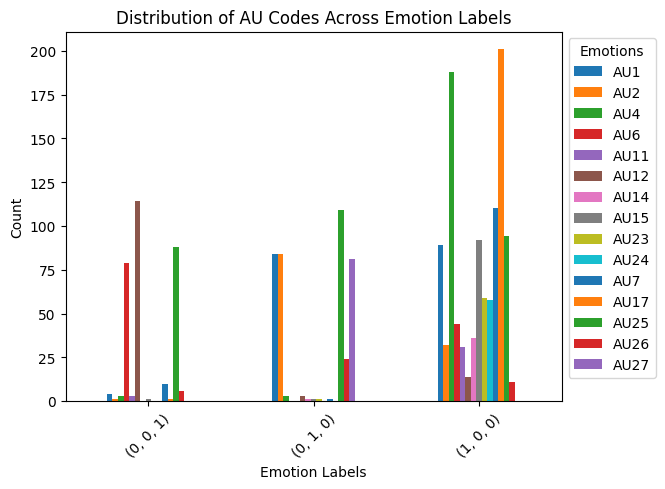

In [113]:
AUcodeColumns = ['AU1','AU2','AU4','AU6','AU11','AU12','AU14','AU15','AU23','AU24','AU7','AU17','AU25','AU26','AU27']

# Define the emotion column names
emotion_column_names = ['negative', 'surprise', 'positive']

# Mapping for emotion categories
mapping = {
    (1, 0, 0): "Negative",
    (0, 1, 0): "Surprise",
    (0, 0, 1): "Positive"
}

# Group the data by emotion columns and sum the AU code occurrences
grouped_data = data_main.groupby(emotion_column_names)[AUcodeColumns].sum()

# Map the column labels to the provided mapping
grouped_data.rename(columns=mapping, inplace=True)

# Create a bar plot for the grouped data
grouped_data.plot(kind='bar')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.title('Distribution of AU Codes Across Emotion Labels')
plt.xticks(rotation=45)
plt.legend(title='Emotions', bbox_to_anchor=(1, 1))
plt.show()

# Defining the important functions

## Spliting up the test train data set

In [9]:
def split_data(data_df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=None):
    target_labels_multi_label_columns = ['AU1', 'AU2', 'AU4', 'AU6', 'AU11', 'AU12', 'AU14', 'AU15', 'AU23', 'AU24', 'AU7', 'AU17', 'AU25', 'AU26', 'AU27']
    target_labels_multi_class_columns = ['negative', 'positive', 'surprise']

    train_data_df, test_and_val_data_df = train_test_split(
        data_df, test_size=(1 - train_size), shuffle=True, random_state=random_state,stratify=data_df[target_labels_multi_class_columns]
    )

    remaining_data_size = test_and_val_data_df.shape[0]
    val_data_size = int(remaining_data_size * (val_size / (val_size + test_size)))

    val_data_df, test_data_df = train_test_split(
        test_and_val_data_df, test_size=test_size / (val_size + test_size), shuffle=True, random_state=random_state,stratify=test_and_val_data_df[target_labels_multi_class_columns]
    )

    print(f"Train data has a shape: {train_data_df.shape}")
    print(f"Val data has shape: {val_data_df.shape}")
    print(f"Test data has shape: {test_data_df.shape}")
    print(f"Total samples: {train_data_df.shape[0] + val_data_df.shape[0] + test_data_df.shape[0]}")

    return train_data_df, val_data_df, test_data_df

#


## Data generator

In [19]:


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame,target_labels_multi_label_columns,target_labels_multi_class_columns, batch_size=8, dim=(256, 256, 3),
                  data_mean=0, data_std=1,  data_prefix='', shuffle=True, Augment=True):
        'Initialization'
        self.dim = dim  # Dimentions of the input
        self.batch_size = batch_size
        self.n_lable_classes = len(target_labels_multi_label_columns)
        self.n_multi_classes = len(target_labels_multi_class_columns)
        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch
        self.Augment = Augment  # Falg to augmetn the data

        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame
        self.target_labels_multi_label_columns = target_labels_multi_label_columns
        self.target_labels_multi_class_columns = target_labels_multi_class_columns
        self.image_multi_label = data_frame[target_labels_multi_label_columns].values.tolist()
        self.image_multi_class = data_frame[target_labels_multi_class_columns].values.tolist()
        self.image_ids = np.arange(len(self.image_multi_label)).tolist()
        self.data_prefix = data_prefix

        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in indexes]
        image_multi_label_temp = [self.image_multi_label[k] for k in indexes]
        image_multi_class_temp = [self.image_multi_class[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(data_ids_temp, image_multi_label_temp,image_multi_class_temp)

        return X, [y[0], y[1]]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    # Support function

    def __data_generation(self, data_ids_temp, image_multi_label_temp,image_multi_class_temp):
        'Generates data containing batch_size samples'

        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y_label = np.empty((self.batch_size, self.n_lable_classes), dtype=int)
        y_class = np.empty((self.batch_size, self.n_multi_classes), dtype=int)

        # Generate data
        for i, ids in enumerate(data_ids_temp):

            X[i,] = self.__read_data_instance(data_ids_temp[i])
            y_label[i] = image_multi_label_temp[i]
            y_class[i] = image_multi_class_temp[i]

        return X,[y_label, y_class]


    def __read_data_instance(self, pid):
        # Read an image
        filepath = self.data_prefix + self.data_frame.iloc[pid]['filepath']
        #print(filepath)
        data = cv2.imread(filepath)  # Read the image using OpenCV
        data = data.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

        if self.Augment:
                      # Apply zoom augmentation to all images
            #zoom_factor = np.random.uniform(1.15, 1.35)  # Adjust the range as needed
            #data = zoom(data, (zoom_factor, zoom_factor, 1), mode='constant', cval=0.0, prefilter=False)

            # Apply rotation with a probability of 0.5
            rot = np.random.rand(1) < 0.5
            if rot:
                angle = np.random.randint(-15, 15, size=1)[0]
                data = rotate(data, angle=angle, reshape=False)  # Rotate the image



            # Apply shear augmentation
            #shear_factor = np.random.uniform(-0.15, 0.15)  # Adjust the range as needed
            #shear_matrix = np.array([[1, shear_factor, 0], [0, 1, 0], [0, 0, 1]])
            #data = affine_transform(data, shear_matrix)

            # Apply brightness augmentation
            #brightness_factor = np.random.uniform(0.6, 1.2)
            #data *= brightness_factor
            #data = np.clip(data, 0, 255)  # Ensure pixel values stay within 0-255 range

            # Apply horizontal flip with a probability of 0.5
            flip = np.random.rand(1) < 0.5
            if flip:
                data = np.fliplr(data)

            # Apply custom padding
            padded_data = np.zeros_like(data)
            padded_data[:data.shape[0], :data.shape[1], :] = data
            data = padded_data

        data = cv2.resize(data, (256, 256))  # Resize the image to 42x42 pixels

        X = data  # The preprocessed image

        return X



## Accuracy and loss calculation and plotting function

In [ ]:
def plot_multioutput_metrics(history):
    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.plot(history.history.get('multi_label_branch_binary_accuracy', []))
    ax1.plot(history.history.get('val_multi_label_branch_binary_accuracy', []))
    ax1.set_title('Multi-label Branch Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(history.history.get('multi_label_branch_loss', []))
    ax2.plot(history.history.get('val_multi_label_branch_loss', []))
    ax2.set_title('Multi-label Branch Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    ax3 = fig.add_subplot(2, 3, 3)
    ax3.plot(history.history.get('multi_label_branch_auc_4', []))
    ax3.plot(history.history.get('val_multi_label_branch_auc_4', []))
    ax3.set_title('Multi-label Branch AUC')
    ax3.set_ylabel('AUC')
    ax3.set_xlabel('Epoch')
    ax3.legend(['Train', 'Validation'], loc='upper left')

    ax4 = fig.add_subplot(2, 3, 4)
    ax4.plot(history.history.get('multi_class_branch_accuracy', []))
    ax4.plot(history.history.get('val_multi_class_branch_accuracy', []))
    ax4.set_title('Multi-class Branch Accuracy')
    ax4.set_ylabel('Accuracy')
    ax4.set_xlabel('Epoch')
    ax4.legend(['Train', 'Validation'], loc='upper left')

    ax5 = fig.add_subplot(2, 3, 5)
    ax5.plot(history.history.get('multi_class_branch_loss', []))
    ax5.plot(history.history.get('val_multi_class_branch_loss', []))
    ax5.set_title('Multi-class Branch Loss')
    ax5.set_ylabel('Loss')
    ax5.set_xlabel('Epoch')
    ax5.legend(['Train', 'Validation'], loc='upper left')

    ax6 = fig.add_subplot(2, 3, 6)
    ax6.plot(history.history.get('loss', []))
    ax6.plot(history.history.get('val_loss', []))
    ax6.plot(history.history.get('multi_label_branch_binary_accuracy', []))
    ax6.plot(history.history.get('val_multi_label_branch_binary_accuracy', []))
    ax6.set_title('Model Loss and Accuracy')
    ax6.set_ylabel('Value')
    ax6.set_xlabel('Epoch')
    ax6.legend(['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()




## Visualize augmented images

In [117]:
def visualize_augmented_images(generator, mapping, num_images=9):
    images, labels = generator.__getitem__(0)  # Fetch the first batch, you can change the index

    # Convert one-hot encoded labels to tuple format for comparison with the mapping
    label_tuples = [tuple(label) for label in labels[1]]

    # Visualize the augmented images
    plt.figure(figsize=(9, 9))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  # Assuming images are already normalized

        # Get the corresponding emotion if it matches the mapping
        if label_tuples[i] in mapping:
            emotion = mapping[label_tuples[i]]
            plt.title(f"Label: {emotion}")
        else:
            plt.title("Unknown Label")

        plt.axis("off")

    plt.show()

# Define the mapping of class indices to emotions
mapping = {
    (1, 0, 0): "Negative",
    (0, 1, 0): "Happy",
    (0, 0, 1): "Surprise"
}

## Visualize AU class distribution

In [118]:
def visualize_AU_class_distribution(train_data, test_data):
    AU_code_columns = ['AU1', 'AU2', 'AU4', 'AU6', 'AU11', 'AU12', 'AU14', 'AU15', 'AU23', 'AU24', 'AU7', 'AU17', 'AU25', 'AU26', 'AU27']
    # Calculate class distribution for train and test subsets
    train_class_distribution = train_data[AU_code_columns].sum()
    test_class_distribution = test_data[AU_code_columns].sum()

    # Create bar plots for class distribution in train and test subsets
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    train_class_distribution.plot(kind='bar')
    plt.xlabel('AU Codes')
    plt.ylabel('Count')
    plt.title('Train Set AU Codes Distribution')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    test_class_distribution.plot(kind='bar')
    plt.xlabel('AU Codes')
    plt.ylabel('Count')
    plt.title('Validation Set AU Codes Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


## Visualize class distribution

In [119]:
import matplotlib.pyplot as plt

def visualize_class_distribution(train_data, test_data ):
    target_labels_multi_class_columns = ['negative', 'positive', 'surprise']
    # Calculate class distribution for train and test subsets
    train_class_distribution = train_data[target_labels_multi_class_columns].sum()
    test_class_distribution = test_data[target_labels_multi_class_columns].sum()

    # Create bar plots for class distribution in train and test subsets
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    train_class_distribution.plot(kind='bar')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Train Set Emotion Class Distribution')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    test_class_distribution.plot(kind='bar')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Validation Set Emotion Class Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

## Create Data Generators

In [20]:
def create_data_generators(train_data_df, val_data_df, BATCH_SIZE, prefix,dim=(256, 256, 3)):
    target_labels_multi_label_columns = ['AU1', 'AU2', 'AU4', 'AU6', 'AU11', 'AU12', 'AU14', 'AU15', 'AU23', 'AU24', 'AU7', 'AU17', 'AU25', 'AU26', 'AU27']
    target_labels_multi_class_columns = ['negative','positive','surprise']
    data_std = 255.0
    data_mean = 0.0

    training_generator = DataGenerator(train_data_df, target_labels_multi_label_columns, target_labels_multi_class_columns, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, Augment=True, data_prefix=prefix,dim=(256, 256, 3))
    validation_generator = DataGenerator(val_data_df, target_labels_multi_label_columns, target_labels_multi_class_columns, batch_size=BATCH_SIZE, data_mean=data_mean, data_std=data_std, Augment=False, data_prefix=prefix,dim=(256, 256, 3))

    return training_generator, validation_generator

## Building a Custom CNN model

In [121]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, AUC

def get_common_part(input_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    return model

def get_multioutput_model(common_part):
    input_layer = Input(shape=(256, 256, 3))
    shared_model = common_part(input_layer)

    multi_label_branch = Dense(512, activation='relu')(shared_model)
    multi_label_branch = Dropout(0.3)(multi_label_branch)
    multi_label_branch = Dense(15, activation='sigmoid', name='multi_label_branch')(multi_label_branch)

    multi_class_branch = Dense(512, activation='relu')(shared_model)
    multi_class_branch = Dropout(0.4)(multi_class_branch)
    multi_class_branch = Dense(3, activation='softmax', name='multi_class_branch')(multi_class_branch)

    multioutput_model = Model(inputs=input_layer, outputs=[multi_label_branch, multi_class_branch])
    return multioutput_model

def train_multioutput_model(train_gen, vali_gen):
    common_part = get_common_part()
    multiop_model_after = get_multioutput_model(common_part)

    class CustomModelCheckpoint(ModelCheckpoint):
        def __init__(self, *args, **kwargs):
            super(CustomModelCheckpoint, self).__init__(*args, **kwargs)

        def on_epoch_end(self, epoch, logs=None):
            current_metric = logs.get(self.monitor)
            if current_metric is None:
                return
            if self.monitor_op(current_metric, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current_metric:.5f}, saving model to {self.filepath}")
                self.best = current_metric
                self.model.save_weights(self.filepath, overwrite=True)

    multiop_model_after.compile(optimizer=Adam(learning_rate=1e-3),
                                loss={'multi_label_branch': 'binary_crossentropy', 'multi_class_branch': 'categorical_crossentropy'},
                                metrics={'multi_label_branch': [BinaryAccuracy(), AUC()],'multi_class_branch': 'accuracy'}
)

    custom_checkpoint = CustomModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/data-1/best_base_model.h5", monitor='val_multi_class_branch_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_multi_class_branch_accuracy', patience=10, verbose=1, mode='auto', restore_best_weights=True)
    callbacks = [custom_checkpoint, early_stopping]

    history = multiop_model_after.fit(train_gen, epochs=100, validation_data=vali_gen, verbose=1, callbacks=callbacks)

    return history

## Pre-processing - Getting facial features from data using haarcascades

In [15]:
import cv2
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_images(df):
    face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/data-1/haarcascade_frontalface_default.xml')

    # Prefix to be added to file paths
    prefix = "/content/drive/MyDrive/Colab Notebooks/data-1/"

    # List to store resized images

    # Iterate through DataFrame rows to process images
    for index, file_path in df['filepath'].iteritems():
        input_file_path = prefix + file_path

        img = cv2.imread(input_file_path)

        if img is None:
            print(f"Failed to read image: {input_file_path}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        try:
            for i, (x, y, w, h) in enumerate(faces):
                cropped_face = img[y:y+h, x:x+w]
                lower_part_height = int(h * 0.8)
                lower_part = cropped_face[h - lower_part_height:h, :]
                resized = cv2.resize(lower_part, (256, 256))

                resized = cv2.GaussianBlur(resized, (5, 5), 0)
                resized = cv2.Canny(cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY), threshold1=30, threshold2=100)
                # Extract the filename and directory from the file path
                file_name = os.path.basename(file_path)
                file_dir = os.path.dirname(file_path)

                # Create output directory including subdirectories
                output_directory = os.path.join(prefix, "extracted_faces", file_dir)
                os.makedirs(output_directory, exist_ok=True)

                # Save the resized image with the same filename and format
                output_path = os.path.join(output_directory, file_name)
                cv2.imwrite(output_path, resized)  # Convert to grayscale before saving

        except:
            print(f"No faces detected in image: {input_file_path}")

## visualizing the predicted emotions

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_predicted_emotions(model_path, data_iterator, mapping, num_images=5):
    """
    Visualizes images with their actual and predicted emotions using a trained model.

    Parameters:
        - model_path (str): Path to the saved Keras model.
        - data_iterator (iterable): An iterable providing batches of images and labels.
        - mapping (dict): A mapping from one-hot-encoded labels to emotion labels.
        - num_images (int): Number of images to visualize.

    Returns:
        None (displays the plot).
    """
    # Load the model from the file path
    model = tf.keras.models.load_model(model_path)

    # Get one batch from the iterator
    batch = next(data_iterator)
    batch_images, batch_labels = batch

    # Predict emotions using the model
    predictions = model.predict(batch_images)

    actual_emotions = []  # Store the actual emotions here
    for i in range(0, len(batch_labels[1])):
        emotion_tuple = tuple(batch_labels[1][i])
        actual_emotions.append(emotion_tuple)

    predicted_emotions = []  # Store the predicted emotions here
    for i in range(0, len(predictions[1])):
        max_position = np.argmax(predictions[1][i])
        tuple_with_max_position = (1 if j == max_position else 0 for j in range(3))
        tuple_with_max_position = tuple(tuple_with_max_position)
        predicted_emotions.append(tuple_with_max_position)

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(batch_images[i])  # Assuming images are already normalized
        plt.axis('off')
        if actual_emotions[i] in mapping:
            actual_emotion = mapping[actual_emotions[i]]
            predicted_emotion = mapping[predicted_emotions[i]]
            plt.title(f"Actual: {actual_emotion}\nPredicted: {predicted_emotion}")
        else:
            plt.title("Unknown Label")

    plt.tight_layout()
    plt.show()


## Confusion matrix and f1 score

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_score, recall_score, accuracy_score

def visualize_confusion_matrix_and_metrics(model_path, data_iterator, mapping):
    """
    Visualizes a confusion matrix and computes classification metrics for a trained model.

    Parameters:
        - model_path (str): Path to the saved Keras model.
        - data_iterator (iterable): An iterable providing batches of images and labels.
        - mapping (dict): A mapping from one-hot-encoded labels to emotion labels.

    Returns:
        None (displays the plots and prints the metrics).
    """
    # Load the model from the file path
    model = tf.keras.models.load_model(model_path)

    # Get all batches from the iterator and concatenate them
    batch = next(data_iterator)
    batch_images, batch_labels = batch

    # Predict emotions using the model
    predictions = model.predict(batch_images)

    actual_emotions = []  # Store the actual emotions here
    for i in range(0, len(batch_labels[1])):
        emotion_tuple = tuple(batch_labels[1][i])
        emotion_tuple = mapping[emotion_tuple]
        actual_emotions.append(emotion_tuple)

    predicted_emotions = []  # Store the predicted emotions here
    for i in range(0, len(predictions[1])):
        max_position = np.argmax(predictions[1][i])
        tuple_with_max_position = (1 if j == max_position else 0 for j in range(3))
        tuple_with_max_position = tuple(tuple_with_max_position)
        tuple_with_max_position = mapping[tuple_with_max_position]
        predicted_emotions.append(tuple_with_max_position)

    actual_labels = actual_emotions
    pred_labels = predicted_emotions
    data = {'y_Actual': actual_labels, 'y_Predicted': pred_labels}
    df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    correct_predictions = sum(map(lambda x, y: x == y, pred_labels, actual_labels))


    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision, recall, accuracy, and F1 score
    precision = precision_score(actual_emotions, predicted_emotions, average='weighted')
    recall = recall_score(actual_emotions, predicted_emotions, average='weighted')
    accuracy = accuracy_score(actual_emotions, predicted_emotions)
    f1 = f1_score(actual_emotions, predicted_emotions, average='weighted')

    # Print the metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

#-------------------------------------------------------------------------------#

.

.

.

# Baseline Model

## Spliting the test and train data

In [125]:
train_data_df, val_data_df, test_data_df = split_data(data_main)

Train data has a shape: (391, 19)
Val data has shape: (84, 19)
Test data has shape: (85, 19)
Total samples: 560


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


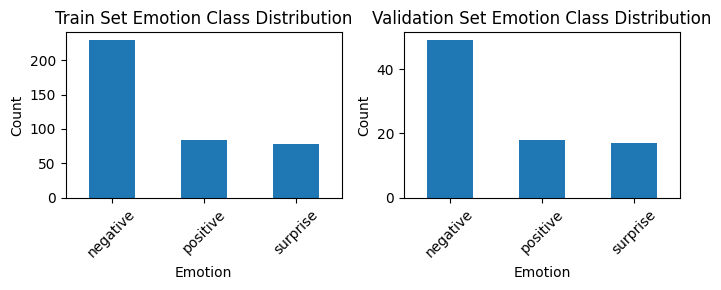

In [126]:
# Call the function with your train_data and test_data DataFrames
visualize_class_distribution(train_data_df, val_data_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


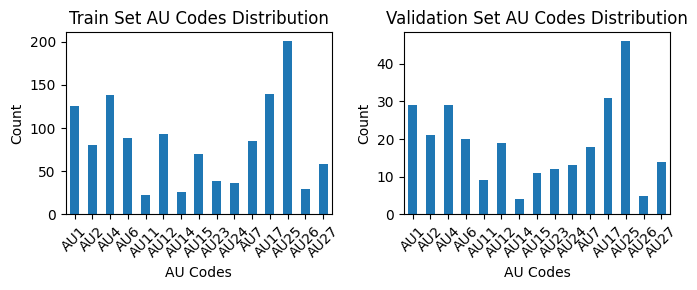

In [127]:
visualize_AU_class_distribution(train_data_df, val_data_df)

## Train and test Generator

In [128]:
BATCH_SIZE = 8  # Batch size
prefix = '/content/drive/MyDrive/Colab Notebooks/data-1/'  # Prefix for file paths

# Create data generators using the function
training_generator, validation_generator = create_data_generators(train_data_df, val_data_df, BATCH_SIZE, prefix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Checking the shape

In [129]:
images, labels = training_generator.__getitem__(12)

print("Images shape:", images.shape)
print("Labels shape:", labels[0].shape)
print("Labels shape:", labels[1].shape)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Images shape: (8, 256, 256, 3)
Labels shape: (8, 15)
Labels shape: (8, 3)


## Visualize augmented images

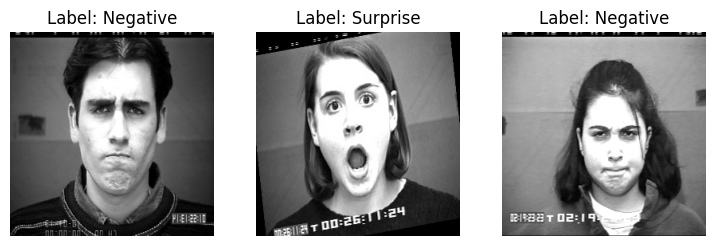

In [130]:
# Call the function to visualize augmented images
visualize_augmented_images(training_generator, mapping, num_images=3)

## Baseline model fitiing

In [131]:
# Train the model
history_baseline_model = train_multioutput_model(training_generator, validation_generator)

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 1.6927 - multi_label_branch_loss: 0.5713 - multi_class_branch_loss: 1.1213 - multi_label_branch_binary_accuracy: 0.7727 - multi_label_branch_auc_2: 0.6260 - multi_class_branch_accuracy: 0.5703
Epoch 1: val_multi_class_branch_accuracy improved from -inf to 0.57500, saving model to /content/drive/MyDrive/Colab Notebooks/data-1/best_base_model.h5
48/48 [==============================] - 78s 2s/step - loss: 1.6927 - multi_label_branch_loss: 0.5713 - multi_class_branch_loss: 1.1213 - multi_label_branch_binary_accuracy: 0.7727 - multi_label_branch_auc_2: 0.6260 - multi_class_branch_accuracy: 0.5703 - val_loss: 1.4708 - val_multi_label_branch_loss: 0.4960 - val_multi_class_branch_loss: 0.9748 - val_multi_label_branch_binary_accuracy: 0.7817 - val_multi_label_branch_auc_2: 0.6878 - val_multi_class_branch_accuracy: 0.5750
Epoch 2/100
48/48 [==============================] - 64s 1s/step - loss: 1.4784 - multi_label_branch_loss:

## Plotting the Metrics

In [132]:
print(history_baseline_model.history.keys())

dict_keys(['loss', 'multi_label_branch_loss', 'multi_class_branch_loss', 'multi_label_branch_binary_accuracy', 'multi_label_branch_auc_2', 'multi_class_branch_accuracy', 'val_loss', 'val_multi_label_branch_loss', 'val_multi_class_branch_loss', 'val_multi_label_branch_binary_accuracy', 'val_multi_label_branch_auc_2', 'val_multi_class_branch_accuracy'])


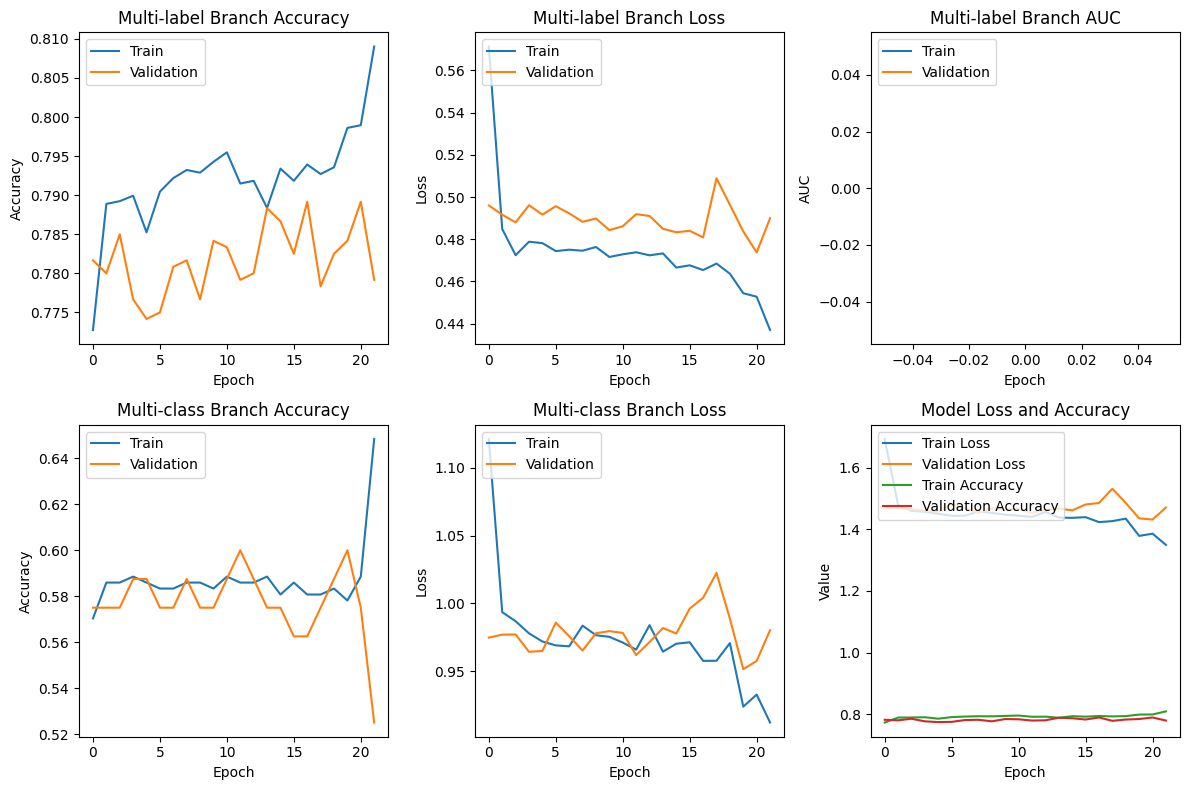

In [133]:
plot_multioutput_metrics(history_baseline_model)


#Getting facial features from data using haarcascades and fitting the model again

## Preprocessing the data

In [134]:
preprocess_images(train_data_df)
preprocess_images(val_data_df)

## Train and test generator

In [135]:
BATCH_SIZE = 8  # Batch size
prefix = '/content/drive/MyDrive/Colab Notebooks/data-1/extracted_faces/'  # Prefix for file paths
dim=(256, 256, 3)
# Create data generators using the function
train_gen_facedet, vali_gen_facedet = create_data_generators(train_data_df, val_data_df, BATCH_SIZE, prefix,dim)

## Checking the shape

In [136]:
images, labels = train_gen_facedet.__getitem__(12)

print("Images shape:", images.shape)
print("Labels shape:", labels[0].shape)
print("Labels shape:", labels[1].shape)

Images shape: (8, 256, 256, 3)
Labels shape: (8, 15)
Labels shape: (8, 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visulize the augmented image

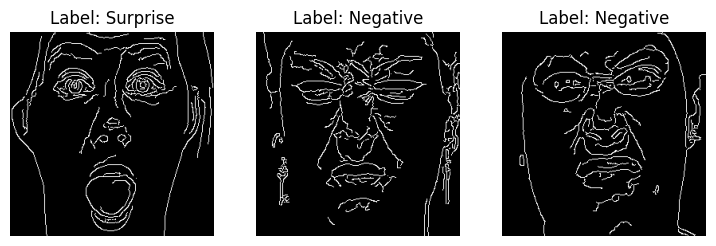

In [137]:
# Call the function to visualize augmented images
visualize_augmented_images(train_gen_facedet, mapping, num_images=3)

## Fitting the pre processed images to base model

In [138]:
# Train the model
history_preprocessed_images = train_multioutput_model(train_gen_facedet, vali_gen_facedet)

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 1.8321 - multi_label_branch_loss: 0.5555 - multi_class_branch_loss: 1.2766 - multi_label_branch_binary_accuracy: 0.7771 - multi_label_branch_auc_3: 0.6717 - multi_class_branch_accuracy: 0.5938
Epoch 1: val_multi_class_branch_accuracy improved from -inf to 0.77500, saving model to /content/drive/MyDrive/Colab Notebooks/data-1/best_base_model.h5
48/48 [==============================] - 73s 1s/step - loss: 1.8321 - multi_label_branch_loss: 0.5555 - multi_class_branch_loss: 1.2766 - multi_label_branch_binary_accuracy: 0.7771 - multi_label_branch_auc_3: 0.6717 - multi_class_branch_accuracy: 0.5938 - val_loss: 1.0087 - val_multi_label_branch_loss: 0.4275 - val_multi_class_branch_loss: 0.5812 - val_multi_label_branch_binary_accuracy: 0.8258 - val_multi_label_branch_auc_3: 0.7888 - val_multi_class_branch_accuracy: 0.7750
Epoch 2/100
48/48 [==============================] - 64s 1s/step - loss: 1.0058 - multi_label_branch_loss:

## Plotting the metrics

In [139]:
print(history_preprocessed_images.history.keys())

dict_keys(['loss', 'multi_label_branch_loss', 'multi_class_branch_loss', 'multi_label_branch_binary_accuracy', 'multi_label_branch_auc_3', 'multi_class_branch_accuracy', 'val_loss', 'val_multi_label_branch_loss', 'val_multi_class_branch_loss', 'val_multi_label_branch_binary_accuracy', 'val_multi_label_branch_auc_3', 'val_multi_class_branch_accuracy'])


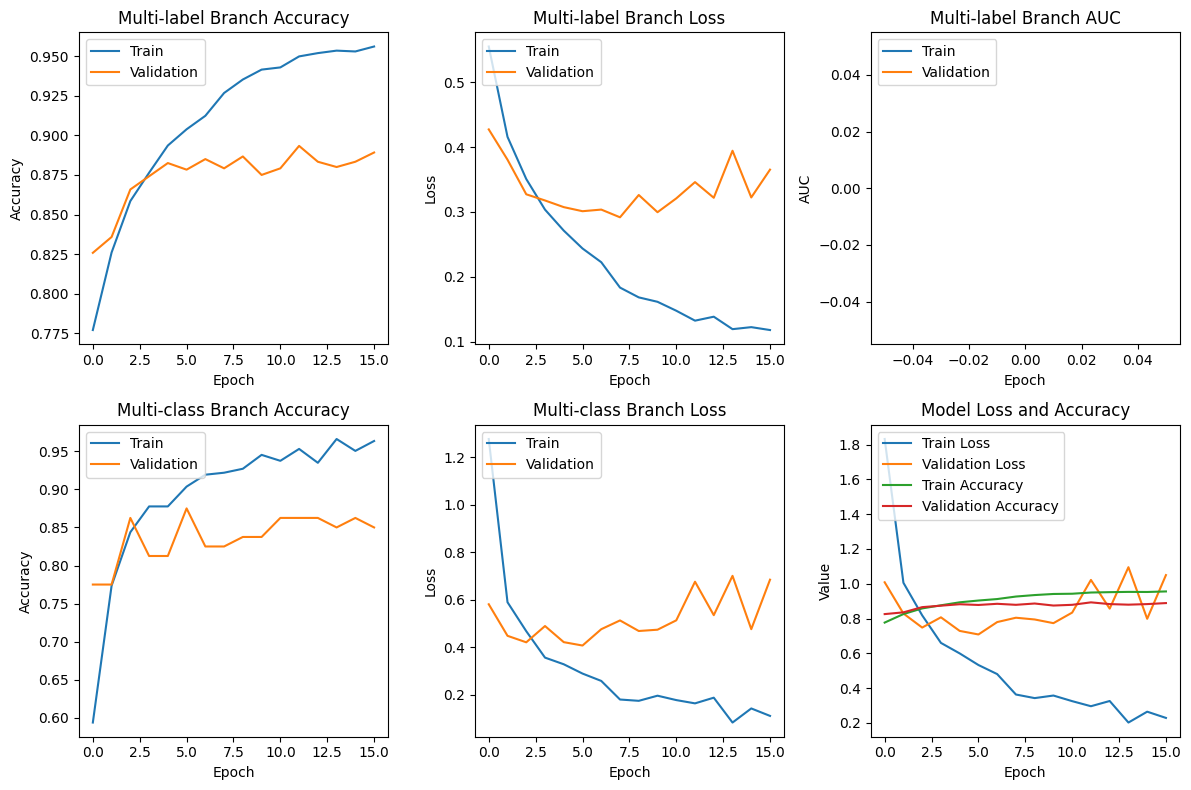

In [140]:
plot_multioutput_metrics(history_preprocessed_images)

# Other techniques to imporve the model generalization

## Importing the data

In [7]:
# reading the data from data_labels_mainData csv files
data_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data-1/data_labels.csv')

# Perform one-hot encoding using pandas' get_dummies function

one_hot_encoded = pd.get_dummies(data_main['high_level_emotion'])
data_main.drop('high_level_emotion', axis=1, inplace=True)
data_main = pd.concat([data_main, one_hot_encoded], axis=1)

columns_to_drop = ['subject', 'sequence', 'image_index','file_prefix']

data_main = data_main.drop(columns=columns_to_drop)


nan_values = data_main.isna().sum()

# Print columns with NaN values and their counts
print(nan_values[nan_values > 0])

data_main['AU25'] = data_main['AU25'].fillna(int(0))


AU25    1
dtype: int64


## Test train and validation split

In [11]:
train_df, valadiation_df, test_df = split_data(data_main)

Train data has a shape: (391, 19)
Val data has shape: (84, 19)
Test data has shape: (85, 19)
Total samples: 560


## balancing  the test data on high level emotion

In [12]:
import cv2
import numpy as np
import pandas as pd
import os
import shutil

# Load your DataFrame
df = train_df

# Define the columns for AU codes
au_columns = ["AU17", "AU1", "AU2", "AU25", "AU27", "AU4", "AU7", "AU23", "AU24", "AU6", "AU12", "AU15", "AU14", "AU11", "AU26"]

# Define the augmentation factor (double the images)
augmentation_factor = 1

# Define the prefix for the file path
file_path_prefix = "/content/drive/MyDrive/Colab Notebooks/data-1/"

# Define the path for augmented images
augmented_dir = file_path_prefix + "augmented_images/"  # Include the prefix

# Clean the directory if it exists
if os.path.exists(augmented_dir):
    shutil.rmtree(augmented_dir)

# Create the directory
os.makedirs(augmented_dir)

# Create a copy of the DataFrame to store augmented image details
augmented_df = df.copy()

# Loop through each row
for index, row in df.iterrows():
    if row["positive"] == 1 or row["surprise"] == 1:
        image_path = file_path_prefix + row["filepath"]  # Include the prefix
        img = cv2.imread(image_path)

        # Apply augmentation
        for i in range(augmentation_factor):
            # Perform augmentation (e.g., flipping)
            augmented_img = np.fliplr(img)

            # Save the augmented image
            class_name = "positive" if row["positive"] == 1 else "surprise"
            class_dir = augmented_dir + class_name
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)  # Create class directory if it doesn't exist
            image_name = os.path.basename(row["filepath"])
            augmented_path = f"./augmented_images/{class_name}/{image_name}_aug_{i}.jpg"
            cv2.imwrite(file_path_prefix+augmented_path, augmented_img)

            # Update augmented DataFrame with augmented image details, AU codes, and class labels
            new_row = row.copy()
            new_row["filepath"] = augmented_path
            for au_column in au_columns:
                new_row[au_column] = row[au_column]  # Copy AU codes
            new_row["negative"] = 0
            new_row["positive"] = 1 if class_name == "positive" else 0
            new_row["surprise"] = 1 if class_name == "surprise" else 0

            augmented_df = augmented_df.append(new_row, ignore_index=True)

<ipython-input-12-2765add43bfd>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)


#### Class distribution before and after augmentation on train sample

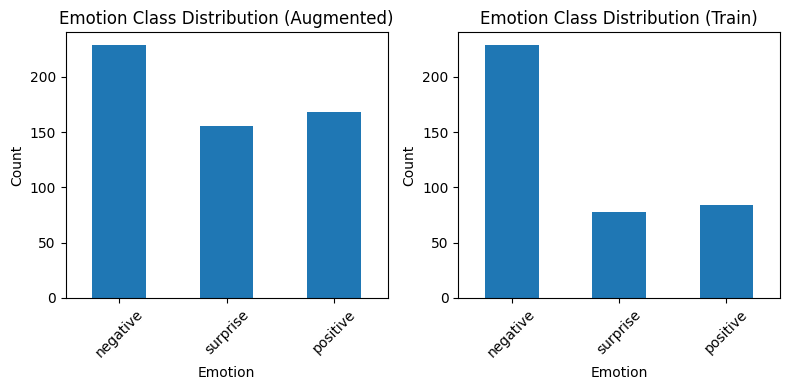

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Plot for augmented_df
target_column_name = ['negative', 'surprise', 'positive']
class_distribution = augmented_df[target_column_name].sum()
class_distribution.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].set_title('Emotion Class Distribution (Augmented)')
axes[0].set_xticklabels(target_column_name, rotation=45)

# Plot for train_df
target_column_name = ['negative', 'surprise', 'positive']
class_distribution = train_df[target_column_name].sum()
class_distribution.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].set_title('Emotion Class Distribution (Train)')
axes[1].set_xticklabels(target_column_name, rotation=45)

plt.tight_layout()
plt.show()

In [173]:
print(augmented_df[target_column_name].sum())
print(train_df[target_column_name].sum())

negative    229
surprise    156
positive    168
dtype: int64
negative    229
surprise     78
positive     84
dtype: int64


### AU Code distribution

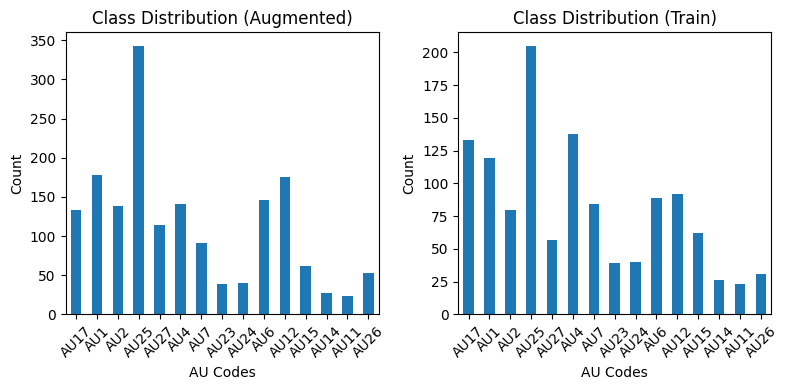

In [174]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
AUcodeColumns = ["AU17", "AU1", "AU2", "AU25", "AU27", "AU4", "AU7", "AU23", "AU24", "AU6", "AU12", "AU15", "AU14", "AU11", "AU26"]
# Plot for augmented_df
class_distribution = augmented_df[AUcodeColumns].sum()
class_distribution.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('AU Codes')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Augmented)')
axes[0].set_xticklabels(AUcodeColumns, rotation=45)

# Plot for train_df
class_distribution = train_df[AUcodeColumns].sum()
class_distribution.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('AU Codes')
axes[1].set_ylabel('Count')
axes[1].set_title('Class Distribution (Train)')
axes[1].set_xticklabels(AUcodeColumns, rotation=45)

plt.tight_layout()
plt.show()

## Preprocessing

In [175]:
preprocess_images(augmented_df)
preprocess_images(valadiation_df)

##Train and Test generator

In [176]:
preprocess_images(valadiation_df)
BATCH_SIZE = 16  # Batch size
prefix = '/content/drive/MyDrive/Colab Notebooks/data-1/extracted_faces/'  # Prefix for file paths

# Create data generators using the function
train_gen, valid_gen = create_data_generators(augmented_df, valadiation_df, BATCH_SIZE, prefix)

In [177]:
images, labels = train_gen.__getitem__(12)

print("Images shape:", images.shape)
print("Labels shape:", labels[0].shape)
print("Labels shape:", labels[1].shape)

Images shape: (16, 256, 256, 3)
Labels shape: (16, 15)
Labels shape: (16, 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [178]:
images, labels = valid_gen.__getitem__(2)

print("Images shape:", images.shape)
print("Labels shape:", labels[0].shape)
print("Labels shape:", labels[1].shape)

Images shape: (16, 256, 256, 3)
Labels shape: (16, 15)
Labels shape: (16, 3)


## Visulizing the Train data

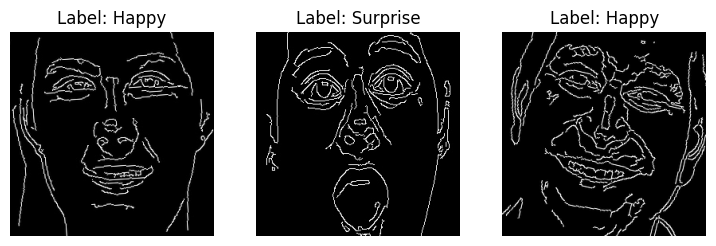

In [179]:
visualize_augmented_images(train_gen, mapping, num_images=3)

##Visulizing the validation data

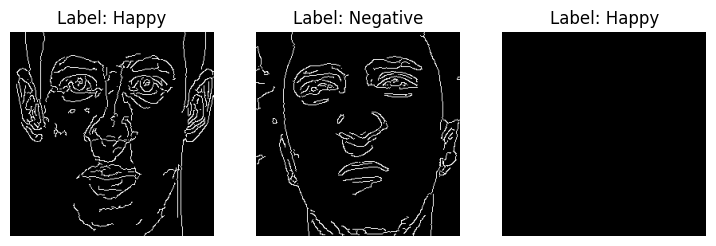

In [180]:
visualize_augmented_images(valid_gen, mapping, num_images=3)

##Modifiing the base model

In [181]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, AUC
import tensorflow.keras.backend as K
from keras.callbacks import Callback

def get_common_part(input_shape=(256, 256, 3)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    return model

def get_multioutput_model(common_part):
    input_layer = Input(shape=(256, 256, 3))
    shared_model = common_part(input_layer)

    multi_label_branch = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(shared_model)
    multi_label_branch = Dropout(0.3)(multi_label_branch)
    multi_label_branch = Dense(15, activation='sigmoid', name='multi_label_branch', kernel_regularizer=tf.keras.regularizers.l2(0.01))(multi_label_branch)

    multi_class_branch = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(shared_model)
    multi_class_branch = Dropout(0.4)(multi_class_branch)
    multi_class_branch = Dense(3, activation='softmax', name='multi_class_branch', kernel_regularizer=tf.keras.regularizers.l2(0.01))(multi_class_branch)

    multioutput_model = Model(inputs=input_layer, outputs=[multi_label_branch, multi_class_branch])
    return multioutput_model

def train_multioutput_model_modified(train_gen, vali_gen):
    common_part = get_common_part()
    multiop_model_after = get_multioutput_model(common_part)

    class CustomModelCheckpoint(Callback):
        def __init__(self, filepath, monitor='val_loss', verbose=0,
                    save_best_only=True, mode='auto'):
            super(CustomModelCheckpoint, self).__init__()
            self.filepath = filepath
            self.monitor = monitor
            self.verbose = verbose
            self.save_best_only = save_best_only
            self.mode = mode
            self.best = np.Inf if self.mode == 'min' else -np.Inf
            if self.mode != 'min' and self.mode != 'max':
                self.mode = 'auto'
            if self.mode == 'min':
                self.monitor_op = np.less
            else:
                self.monitor_op = np.greater

        def on_epoch_end(self, epoch, logs=None):
            current_metric = logs.get(self.monitor)
            if current_metric is None:
                return
            if self.monitor_op(current_metric, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current_metric:.5f}, saving model to {self.filepath}")
                self.best = current_metric
                self.model.save(self.filepath, overwrite=True, include_optimizer=True)

    multiop_model_after.compile(optimizer=Adam(learning_rate=1e-3),
                                loss={'multi_label_branch': 'binary_crossentropy', 'multi_class_branch': 'categorical_crossentropy'},
                                metrics={'multi_label_branch': [BinaryAccuracy(), AUC()], 'multi_class_branch': 'accuracy'}
)

    custom_checkpoint = CustomModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/data-1/best_model.h5", monitor='val_multi_class_branch_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_multi_class_branch_accuracy', patience=10, verbose=10, mode='auto', restore_best_weights=True)
    callbacks = [custom_checkpoint, early_stopping]

    history = multiop_model_after.fit(train_gen, epochs=100, validation_data=vali_gen, verbose=1, callbacks=callbacks)

    return history


## Training model

In [182]:
history_last_model = train_multioutput_model_modified(train_gen, valid_gen)

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 9.0976 - multi_label_branch_loss: 0.5869 - multi_class_branch_loss: 1.8173 - multi_label_branch_binary_accuracy: 0.7939 - multi_label_branch_auc_4: 0.6588 - multi_class_branch_accuracy: 0.4724
Epoch 1: val_multi_class_branch_accuracy improved from -inf to 0.82500, saving model to /content/drive/MyDrive/Colab Notebooks/data-1/best_model.h5
34/34 [==============================] - 104s 3s/step - loss: 9.0976 - multi_label_branch_loss: 0.5869 - multi_class_branch_loss: 1.8173 - multi_label_branch_binary_accuracy: 0.7939 - multi_label_branch_auc_4: 0.6588 - multi_class_branch_accuracy: 0.4724 - val_loss: 3.0242 - val_multi_label_branch_loss: 0.4309 - val_multi_class_branch_loss: 0.4293 - val_multi_label_branch_binary_accuracy: 0.8208 - val_multi_label_branch_auc_4: 0.7635 - val_multi_class_branch_accuracy: 0.8250
Epoch 2/100
34/34 [==============================] - 73s 2s/step - loss: 2.2222 - multi_label_branch_loss: 0.4

In [183]:
print(history_last_model.history.keys())

dict_keys(['loss', 'multi_label_branch_loss', 'multi_class_branch_loss', 'multi_label_branch_binary_accuracy', 'multi_label_branch_auc_4', 'multi_class_branch_accuracy', 'val_loss', 'val_multi_label_branch_loss', 'val_multi_class_branch_loss', 'val_multi_label_branch_binary_accuracy', 'val_multi_label_branch_auc_4', 'val_multi_class_branch_accuracy'])


In [ ]:
plot_multioutput_metrics(history_last_model)

## Testing on unseen data

In [21]:
preprocess_images(test_df)
BATCH_SIZE = 85  # Batch size
prefix = '/content/drive/MyDrive/Colab Notebooks/data-1/extracted_faces/'  # Prefix for file paths

# Create data generators using the function
valid_gen,test1_df = create_data_generators(valadiation_df, test_df, BATCH_SIZE, prefix)

<ipython-input-15-da1bc8c0b136>:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, file_path in df['filepath'].iteritems():


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3/3 [==============================] - 1s 332ms/step


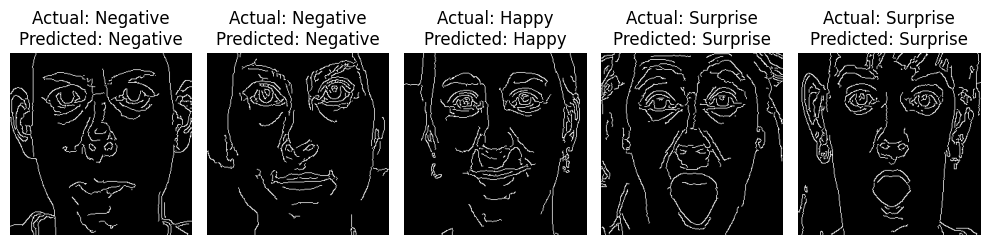

In [186]:
visualize_predicted_emotions('/content/drive/MyDrive/Colab Notebooks/data-1/best_model.h5', iter(test1_df), mapping)

## Confusion Matrix, Precision,Recall,Accuracy,F1 Score for emotion detection

3/3 [==============================] - 1s 323ms/step


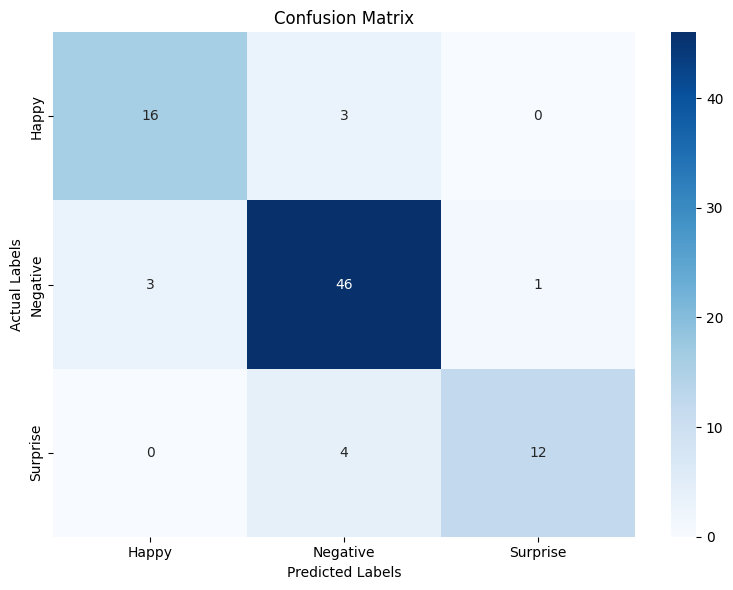

Precision: 0.8725347904038248
Recall: 0.8705882352941177
Accuracy: 0.8705882352941177
F1 Score: 0.8694302762953191


In [187]:
visualize_confusion_matrix_and_metrics('/content/drive/MyDrive/Colab Notebooks/data-1/best_model.h5', iter(test1_df), mapping)

## AUC,Sensitivity,sensitivity,Specificity,Accuracy for FACS code

code is refered form https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b

In [1]:
from tensorflow.keras.models import load_model
loaded_model = load_model("/content/drive/MyDrive/Colab Notebooks/data-1/best_model.h5")

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)

    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)

    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)

    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)

    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)

    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence,
                            spec=specificity,sens=sensitivity, ppv=get_ppv,
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):

    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs



from sklearn.metrics import roc_curve, roc_auc_score

def get_roc_curve(gt, pred, target_names):
    num_classes = len(target_names)
    num_rows = 3  # Number of rows in the grid
    num_cols = (num_classes + num_rows - 1) // num_rows  # Calculate the number of columns

    # Increase the figure size for larger plots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20*num_cols, 10*num_rows))

    for i in range(num_classes):
        row = i // num_cols
        col = i % num_cols
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = f'{target_names[i]}\nAUC: {auc_roc:.3f}'
        xlabel = "False Positive Rate"
        ylabel = "True Positive Rate"
        fpr, tpr, _ = curve_function(gt[:, i], pred[:, i])

        axs[row, col].plot([0, 1], [0, 1], 'k--', label='Random')
        axs[row, col].plot(fpr, tpr, label=label)
        axs[row, col].set_xlabel(xlabel)
        axs[row, col].set_ylabel(ylabel)
        axs[row, col].set_title(f'ROC Curve for {target_names[i]}')
        axs[row, col].legend(loc='lower right')

    plt.tight_layout()
    plt.savefig('ROC_Curves.png')
    plt.show()

def get_PR_curve(gt, pred, target_names):
    fig,axs = plt.subplots(1,len(target_names),figsize=(60,10))
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = target_names[i] + " Avg.: %.3f " % average_precision
        #plt.figure(1, figsize=(7, 7))
        axs[i].step(recall, precision, where='post', label=label)
        axs[i].set_xlabel('Recall')
        axs[i].set_ylabel('Precision')
        axs[i].set_ylim([0.0, 1.05])
        axs[i].set_xlim([0.0, 1.0])
        axs[i].legend(loc='upper center',
                       fancybox=True, ncol=1)
    plt.savefig('Precision_and_Recall_curve.png')
    plt.show()

def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = list(metric_dfs.keys())
    fig,axs = plt.subplots(len(metrics),1,sharey=True,figsize = (4,16))
    for i in range(len(metrics)):
        ci = metric_dfs[metrics[i]][['Mean '+metrics[i]+' (CI 5%-95%)']].values[0]
        ci_mean,ci_ints = ci[0].split(' ')
        ci_mean = float(ci_mean)
        ci_min,ci_max = list(map(float,ci_ints.strip('()').split('-')))
        ci_err = (ci_max-ci_min)/2

        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

In [22]:

pd.options.mode.chained_assignment = None

batch = next(iter(test1_df))
batch_images, batch_labels = batch

# Predict emotions using the model
predictions = loaded_model.predict(batch_images)

test_true = batch_labels[0]

test_preds = predictions[0]
class_names = ['AU1', 'AU2', 'AU4', 'AU6', 'AU11', 'AU12', 'AU14', 'AU15', 'AU23', 'AU24', 'AU7', 'AU17', 'AU25', 'AU26', 'AU27']

perf_df = get_performance_metrics(test_true,test_preds,class_names)


3/3 [==============================] - 1s 322ms/step


<ipython-input-5-5ba0bcd66837>:49: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fp)
<ipython-input-5-5ba0bcd66837>:49: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fp)
<ipython-input-5-5ba0bcd66837>:49: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fp)
<ipython-input-5-5ba0bcd66837>:49: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fp)
<ipython-input-5-5ba0bcd66837>:49: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fp)
<ipython-input-5-5ba0bcd66837>:49: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fp)
<ipython-input-5-5ba0bcd66837>:49: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fp)


In [23]:
import warnings

# Store the previous warning filter state
previous_warning_state = warnings.filterwarnings("ignore")



conf_df = get_confidence_intervals(test_true,test_preds,class_names)

warnings.filterwarnings("default", category=DeprecationWarning)

In [24]:
conf_df

{'AUC':      Mean AUC (CI 5%-95%)
 AU1      0.86 (0.84-0.87)
 AU2      0.95 (0.94-0.96)
 AU4      0.89 (0.88-0.91)
 AU6      0.93 (0.92-0.94)
 AU11     0.55 (0.48-0.61)
 AU12     0.97 (0.96-0.97)
 AU14     0.74 (0.69-0.79)
 AU15     0.86 (0.84-0.88)
 AU23     0.84 (0.81-0.87)
 AU24     0.91 (0.88-0.93)
 AU7      0.78 (0.75-0.81)
 AU17     0.95 (0.94-0.95)
 AU25     0.92 (0.91-0.93)
 AU26     0.76 (0.72-0.79)
 AU27     1.00 (0.99-1.00),
 'Sensitivity':      Mean Sensitivity (CI 5%-95%)
 AU1              0.45 (0.41-0.50)
 AU2              0.59 (0.53-0.66)
 AU4              0.56 (0.52-0.60)
 AU6              0.70 (0.65-0.74)
 AU11             0.00 (0.00-0.00)
 AU12             0.84 (0.81-0.89)
 AU14             0.00 (0.00-0.00)
 AU15             0.00 (0.00-0.00)
 AU23             0.00 (0.00-0.00)
 AU24             0.00 (0.00-0.00)
 AU7              0.00 (0.00-0.00)
 AU17             0.50 (0.43-0.56)
 AU25             0.94 (0.92-0.95)
 AU26             0.00 (0.00-0.00)
 AU27             0.

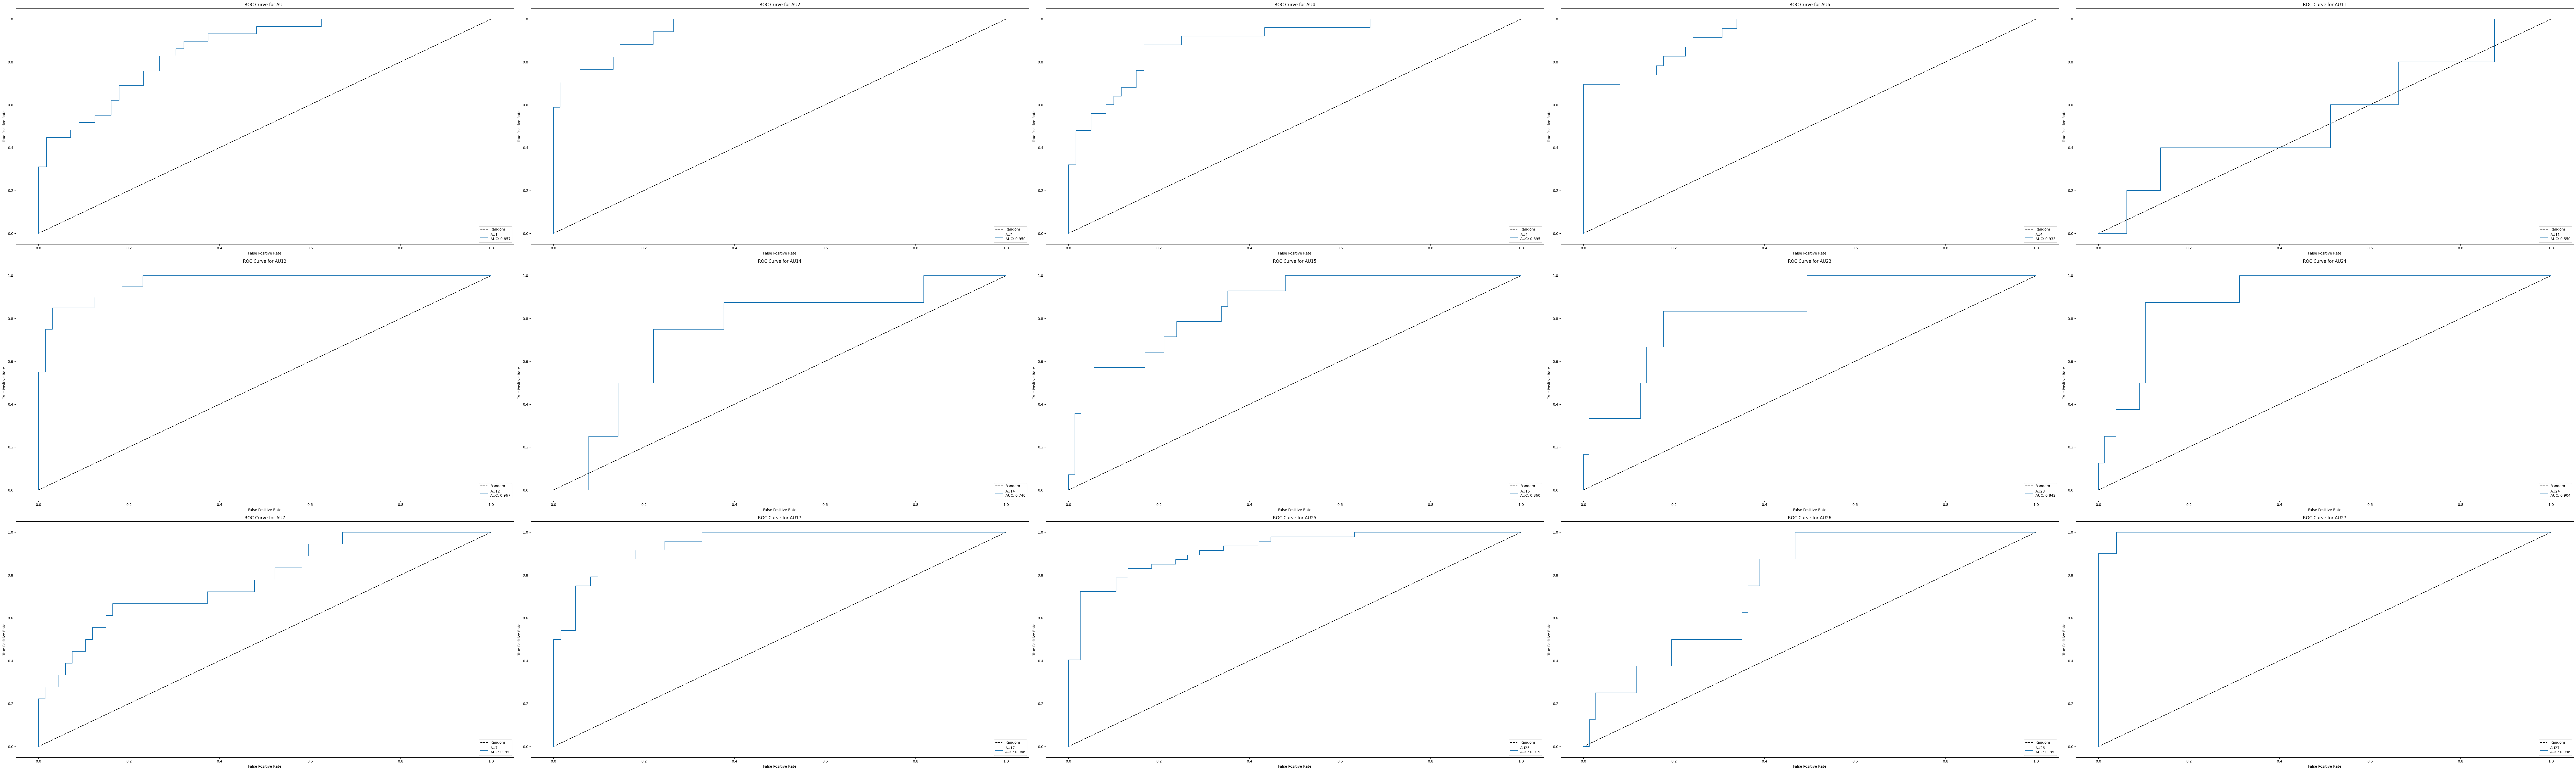

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
get_roc_curve(test_true,test_preds,class_names)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


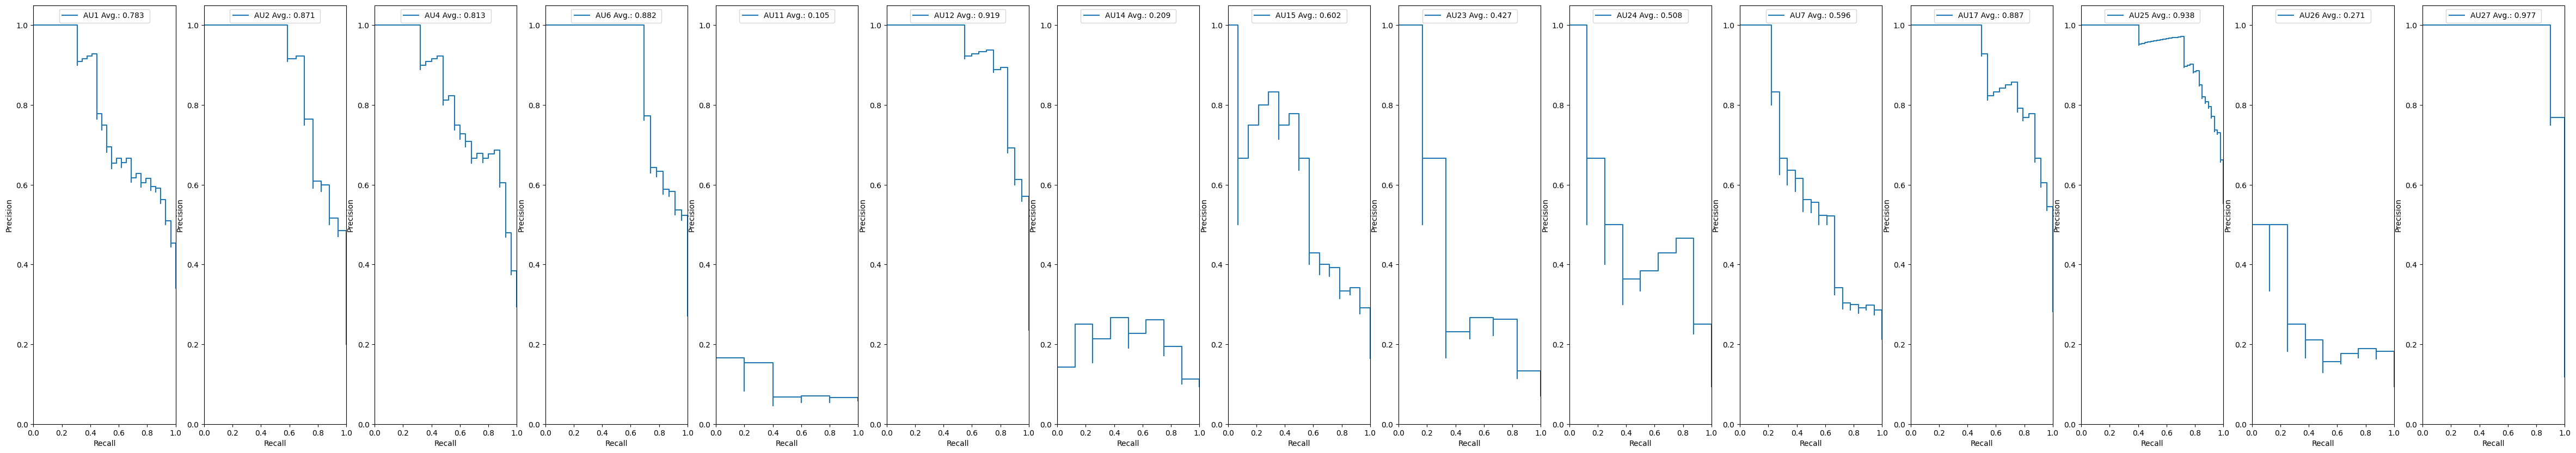

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score


get_PR_curve(test_true,test_preds,class_names)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_predicted_emotions(model_path, data_iterator, num_images=1
                                 ):
    """
    Visualizes images with their actual and predicted emotions using a trained model.

    Parameters:
        - model_path (str): Path to the saved Keras model.
        - data_iterator (iterable): An iterable providing batches of images and labels.
        - mapping (dict): A mapping from one-hot-encoded labels to emotion labels.
        - num_images (int): Number of images to visualize.

    Returns:
        None (displays the plot).
    """
    # Load the model from the file path
    model = tf.keras.models.load_model(model_path)

    # Get one batch from the iterator
    batch = next(data_iterator)
    batch_images, batch_labels = batch

    # Predict emotions using the model
    predictions = model.predict(batch_images)

    actual_emotions = []  # Store the actual emotions here
    for i in range(0, len(batch_labels[0])):
        emotion_tuple = batch_labels[0][i]
        actual_emotions.append(emotion_tuple)

    predicted_emotions = []  # Store the predicted emotions here
    for i in range(0, len(predictions[0])):
        max_position = np.round(predictions[0][i], 2)
        predicted_emotions.append(max_position )

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(batch_images[i])  # Assuming images are already normalized
        plt.axis('off')
        actual_emotion = actual_emotions[i]
        predicted_emotion = predicted_emotions[i]
        plt.title(f"Actual: {actual_emotion}\nPredicted: {predicted_emotion}")

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3/3 [==============================] - 1s 320ms/step


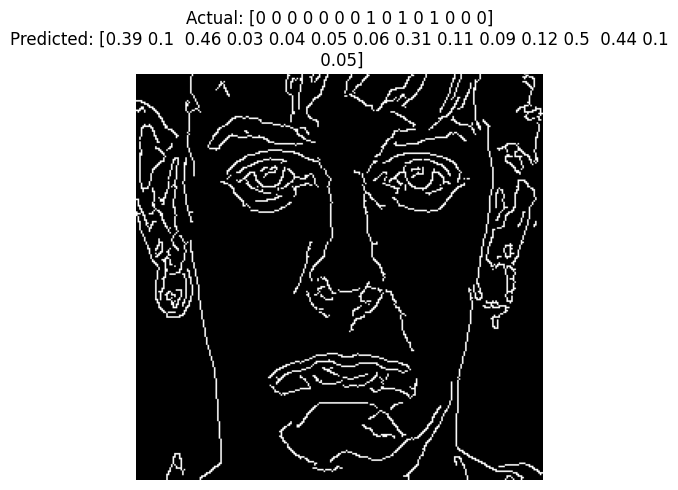

In [28]:
 visualize_predicted_emotions('/content/drive/MyDrive/Colab Notebooks/data-1/best_model.h5', iter(test1_df))